In [4]:
# 11.9 22:17
from neuron import gui,h
import pandas as pd
import seaborn as sns
import pandas as pd
from tqdm.auto import tqdm
from IPython.core.display import display, HTML
import os
h.load_file("nrngui.hoc")
h.load_file("import3d.hoc")
display(HTML("<style>.container { width:100% !important; }</style>"))

%pylab
%matplotlib inline
cells = {'JM072303':{'Rm':1000},'Hay_2011_passive':{'Rm':15000}, 'NMO_130658':{'Rm':3000}, 'NMO_161366':{'Rm':3500}}

cell_name = 'NMO_161366' # decide which cell to process
#NMO_161366  - pyramidal - http://neuromorpho.org/neuron_info.jsp?neuron_name=20180102_sample_1 - https://www.nature.com/articles/s41586-020-2907-3
#NMO_130658 - basket - http://neuromorpho.org/neuron_info.jsp?neuron_name=2017-16-05-slice-1-cell-6-rotated -  https://pubmed.ncbi.nlm.nih.gov/31519874/
#JM072303 - spiny - http://neuromorpho.org/neuron_info.jsp?neuron_name=JM072303 - https://pubmed.ncbi.nlm.nih.gov/16337918/


syn_conds = [0.001] # synaptic conductance to use
nstim_start = 40
cur_amp = 0.1 # nA


def create_cell():
    
    h.load_file("models/Hay_2011_passive/L5PCtemplate.hoc")
    h.load_file("models/Hay_2011_passive/L5PCtemplate_swc.hoc")
    
    if cell_name == 'Hay_2011_passive':
        cell = h.L5PCtemplate('models/Hay_2011_passive/cell1.asc')
    elif cell_name == 'JM072303':
        cell = h.L5PCtemplate('models/JM072303/JM072303.asc')
    elif cell_name =='NMO_130658':
        cell = h.L5PCtemplateswc('models/NMO_130658/2017-13-02-slice-2-cell-3-rotated.SWC')
    elif cell_name =='NMO_161366':
        cell = h.L5PCtemplateswc('models/NMO_161366/20180102_sample_1.SWC')
    h.area(0.5,sec=cell.soma[0]) # make sure diam reflects 3d points

    
    soma = cell.soma[0]
    for sec in h.allsec():
        sec.insert("pas")
        sec.g_pas = 1/cells[cell_name]['Rm']
        sec.cm =1 
        sec.Ra = 100
    
    h("freq = 100")#      // Hz, frequency at which AC length constant will be computedf
    h("d_lambda = 0.1")
    h("forall { nseg = int((L/(d_lambda*lambda_f(freq))+0.9)/2)*2 + 1  }")

    vvec = h.Vector().record(soma(0.5)._ref_v)
    tvec = h.Vector().record(h._ref_t)

    iclamp = h.IClamp(soma(0.5))
    seclamp = h.SEClamp(soma(0.5))
    seclamp_current = h.Vector().record(seclamp._ref_i)

    h.v_init = soma.e_pas


    #check cell input resistance

    imp = h.Impedance()
    imp.loc(0.5,sec=soma)
    imp.compute(0,1)
    Rin = imp.input(0.5,sec=soma)
    return cell, vvec, tvec, iclamp, seclamp, Rin


def create_synapse(seg, e):
    nstim = h.NetStim()
    # set other variables
    nstim.number = 1
    nstim.noise = 0
    nstim.start = nstim_start

    
    dend_syn = h.Exp2Syn(seg)
    dend_syn.tau1=0.0001#0.3
    dend_syn.tau2=9e9#10
    dend_syn.e = e
    
    dend_ncon = h.NetCon(nstim,dend_syn)
    dend_ncon.weight[0] = 0
    
    return nstim, dend_syn, dend_ncon





def get_cell_specs():
    cell, vvec, tvec, iclamp, seclamp, Rin = create_cell()
    all_segs = []
    for sec in h.allsec():
        for seg in sec:
            all_segs.append(seg)
    return Rin, len(all_segs), cell.soma[0].e_pas, cell, vvec, tvec, iclamp, seclamp, Rin

    
def calc_syn_effects(x):
    '''
    x - list of inds for segs to calculate
    '''
    st = x[0] # do seg from st to en
    en = x[1]
    cell, vvec, tvec, iclamp, seclamp, Rin = create_cell()


    h.tstop = nstim_start+100 + 300
    iclamp.delay  = nstim_start+200
    iclamp.dur = h.tstop + 10
    
    iclamp.amp = cur_amp #nA


    h.dt=0.2
    h.steps_per_ms = 1/h.dt


    to_save = {'syn_dv':[], 'iclamp_dv':[], 'seg_dist':[],'seg_length':[],'voltage':[],'synapse_reversal':[],'seg_name':[],'syn_g':[]}
    #syn_dv - dV of synapse
    #iclamp_dv - dV of iclamp, start after synapses
    #syn_g - nanoS

    all_segs = []
    for sec in h.allsec():
        for seg in sec:
            all_segs.append(seg)
    
    if st>len(all_segs):
        return []
    
    all_segs = all_segs[st:en]
    
    for seg in all_segs:
        for syn_cond in syn_conds:
            for syn_e in [0,-80]:
                nstim, dend_syn, dend_ncon  = create_synapse(seg, syn_e)
                dend_ncon.weight[0] =syn_cond

                syn_g = dend_ncon.weight[0]*10**3 #from micro to nano

                h.run()
                #plot(tvec,vvec)
                iclamp_dv = vvec[-1]-vvec[int((iclamp.delay-10)/h.dt)]
                syn_dv  = vvec[int((iclamp.delay-10)/h.dt)]-vvec[10]

                to_save['syn_dv'].append(syn_dv)
                to_save['iclamp_dv'].append(iclamp_dv)
                to_save['seg_dist'].append(h.distance(cell.soma[0](0.5),seg))
                to_save['seg_length'].append(seg.sec.L/seg.sec.nseg)
                to_save['synapse_reversal'].append(syn_e)
                to_save['voltage'].append(list(vvec))
                to_save['syn_g'].append(syn_g)
                to_save['seg_name'].append(str(seg))
                nstim.number = 0
                dend_ncon.weight[0] = 0
                del nstim,dend_ncon,dend_syn

    return to_save

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Calc voltage deflaction per synapse

In [6]:
## test
# data = calc_syn_effects([10,20])
# pd.DataFrame(data)
 
    
chunk_size = 10
max_send = 2500
to_send =[[i*10,(i+1)*10] for i in range(300) if i*10<max_send]
print("if number of segments is larger than 3000, this will be a probalem")

from multiprocessing import Pool

outputs = []
pbar= tqdm(total=len(to_send))
with Pool(processes=5) as pool:
    for out in pool.imap_unordered(calc_syn_effects,to_send):
        pbar.update(1)
        if len(out)>0:
            outputs.append(out)

#merge output
full_dict = {k:[] for k in outputs[0]}
for out in outputs:
    for k in out:
        full_dict[k].extend(out[k])
df = pd.DataFrame(full_dict)

if number of segments is larger than 3000, this will be a probalem


  0%|          | 0/250 [00:00<?, ?it/s]

In [10]:
Rin, segs_num, e_pas, cell, vvec, tvec, iclamp, seclamp, Rin = get_cell_specs()
print(Rin)

62.23537626767067


# Calc Rho and Alpha

In [54]:

df['g_eff'] = None
df['alpha'] = None
df['rho'] = None
df['alpharho'] = None

plotting = False
_,axes = subplots(ncols=4, sharex=True,figsize=(10,3)) if plotting else _,None
for jj,row in df.iterrows():
    
    g_eff = 1/(row['iclamp_dv']/cur_amp)*10**3 #mv/nA ?=uS --*10**3--> nS ?
    df.loc[row.name,'g_eff'] = g_eff
    
    if plotting:
        
        sca(axes[0])
        plot(row['syn_g'],g_eff,'-o')
        xlabel('gs (nS)')
        ylabel('g_eff (nS)')
       

    ## calc ar ###
    ##############
    gl_S = 1/Rin*10**-6 # uS -> S
    cur_amp_A = cur_amp*10**-9 # nA
    dvs_V = row['iclamp_dv']*10**-3 # mV ->V
    g_syns_S = row['syn_g']*10**-9 #  nS ->S    
    ar = ((cur_amp_A/dvs_V)-gl_S)/g_syns_S
    df.loc[row.name,'alpharho'] = ar
    
    if plotting:
        sca(axes[1])
        plot(row['syn_g'],ar ,'-o')
        xlabel('gs (nS)')
        ylabel(r'$\alpha \rho$')




    ## calc alpha ##
    ################
    dvs_fromsyn_V = row['syn_dv']*10**-3 # mV ->V
    g_eff_S = g_eff*10**-9
    V_diff = (e_pas-row['synapse_reversal'])*10**-3 #mV ->V
    g_syns_S
    a = -1*(dvs_fromsyn_V*g_eff_S)/(V_diff*g_syns_S)
    df.loc[row.name,'alpha'] = a
    
    if plotting:
        sca(axes[2])
        tm = ar/a
        plot(row['syn_g'],a ,'-o')
        xlabel('gs (nS)')
        ylabel(r'$\alpha$')
        tight_layout()
        #ylim(min(list(tm) + list(a))-0.01,max(list(tm) + list(a))+0.01) 
    ## calc rho   ##
    ################
    df.loc[row.name,'rho'] = ar/a
    if plotting:
        sca(axes[3])
        plot(row['syn_g'],ar/a ,'-o')
        xlabel('gs (nS)')
        ylabel(r'$\rho$')
        #ylim(min(list(tm) + list(a))-0.01,max(list(tm) + list(a))+0.01) 
        tight_layout()
        #suptitle(f'dist from soma = {row["seg_x"].iloc[0]:9.5} um | loc = {row["seg_obj"].iloc[0]}')
        tight_layout(rect=[0, 0.03, 1, 0.95])
        
    if jj>4:
        plotting = False

# plots

Text(0.5, 0.98, 'NMO_161366')

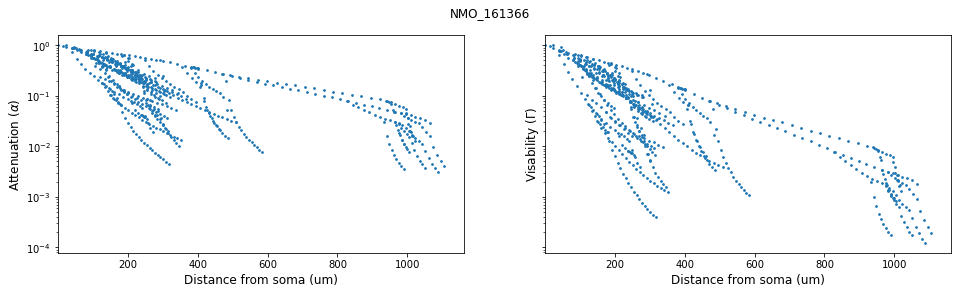

In [55]:
df_ex = df.query('synapse_reversal==0')
fig, axs = subplots(1,2,figsize=(16,4),sharex=True,sharey=True)
plt.sca(axs[0])
plt.scatter(df_ex.seg_dist,df_ex.alpha,s=3)
plt.ylabel(r'Attenuation ($\alpha$)',fontsize=12)
plt.xlabel('Distance from soma (um)',fontsize=12)
plt.sca(axs[1])
plt.scatter(df_ex.seg_dist,df_ex.alpharho,s=3)
plt.ylabel(r'Visability ($\Gamma$)',fontsize=12)
plt.xlabel('Distance from soma (um)',fontsize=12)
plt.yscale('log')
plt.xlim(0.00001,plt.xlim()[1])
plt.suptitle(cell_name)